<div style="text-align: right"> 
<a href='https://d7vw40z4bofef.cloudfront.net/static/2.37.07-web19/images/service/isometric/flight.svg'>image source</a> </div>

<center><a href="https://rapids.ai/"><img src="img/rapids.png" alt="rapids_logo" style="width: 1500px;"/></a></center>

# <font color='#8735fb'> Data Visualization
    
In previous Notebooks, we have downloaded, merged, cleaned, and fully processed a dataset.
    
In this Notebook, we will use that dataset to gain a better intuition of what our data looks like, how the different features relate to each other, and we will see several techniques to visualize the data.
    
Dealing with high-dimensionality data can be very tricky at times. When a dataset starts having tens or hundreds of features, it can become impossible to understand the representation without some sort of visualization or algorithmic analysis. In the following exercise, we will start by looking at the data itself to get a feel for the types and range of values we are dealing with. We'll then create a correlation matrix and plot them using a heatmap. And we will wrap up the exercise with a geographical representation of all the flight data.
    
As you go through these exercises, think about what other aspects of the data you might want to inspect, and think carefully about what the heatmap might indicate about the data.

In [1]:
# Import RAPIDS and other data science tools
import numpy, pandas
import cupy, cudf, cuml # RAPIDS
import teach_ML

# Import & configure some plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display
import ipywidgets
import warnings; warnings.filterwarnings('ignore')

In [2]:
# Define some global directory/file names that change based on the environment

# Set data directory as configured in the workflow
data_dir = '/home/ec2-user/SageMaker/data/'

# Set the name for the previously processed files
processed_data_file = data_dir + 'airlines_processed_data.csv'
processed_data_file_full = data_dir + 'airlines_processed_data_full.csv'#

In [3]:
# Define import column headers for the data

# These are all the columns in the training dataset
train_columns = ['enc_Flight_Number_Reporting_Airline', 'dest_long', 'enc_ArrTime', 'enc_Origin', 'Quarter',
                 'dest_elevation', 'enc_Dest', 'origin_elevation', 'enc_OriginCityName', 'AirTime', 'DestCityMarketID',
                 'origin_lat', 'Month', 'enc_DepTime', 'DepDelay', 'enc_Airline', 'enc_CRSArrTime', 'DayOfWeek',
                 'enc_DestCityName', 'enc_CRSDepTime', 'enc_Reporting_Airline', 'origin_long', 'Distance', 'DepDel15',
                 'dest_lat', 'OriginCityMarketID']

# This is the column the model will predict
predict_column =  ['ArrDel15']

# This is a sorted list of all columns for data visualization and exploration
correlation_columns = sorted(train_columns + predict_column)

In [4]:
# Because we are doing prototyping and exploration during this phase, we begin with the smaller dataset, try uncommenting the second line
processed_data = cudf.read_csv(processed_data_file) # 1 month of data, will run quicker
# processed_data = cudf.read_csv(processed_data_file_full) # 1 year of data, may take longer

### <font color='#8735fb'> Data Summaries


In [5]:
# Some basic information about the size of the data
print(f'Dataset has {processed_data.shape[0]} rows with {processed_data.shape[1]} columns')

Dataset has 620887 rows with 31 columns


In [6]:
# A quick representation of the values in the data
processed_data.head().to_pandas().T

0                   1  \
Unnamed: 0                                            0                   1   
dest_lat                                        40.7857             41.9786   
origin_elevation                                    672                4227   
ArrDelay                                            -23                 -17   
enc_ArrTime                                         971                1267   
Quarter                                               2                   2   
enc_Flight_Number_Reporting_Airline                2308                2308   
DayOfWeek                                             5                   5   
origin_lat                                      41.9786             40.7857   
enc_Origin                                          246                 315   
DepDel15                                              0                   0   
enc_Dest                                            315                 246   
enc_DepTime                                         826                1011   
enc_CRSDepTime                                      635                 818   
DepDelay                                             -6                  -4   
AirTime                                             169                 150   
enc_OriginCityName                                   63                 284   
ArrDel15                                              0                   0   
Distance                                           1250                1250   
dest_long                                       -111.98            -87.9048   
enc_DestCityName                                    284                  63   
OriginCityMarketID                                30977               34614   
enc_Airline                                          13                  13   
dest_elevation                                     4227                 672   
origin_long                                    -87.9048             -111.98   
DestCityMarketID                                  34614               30977   
Month                                                 6                   6   
enc_CRSArrTime                                      880                1170   
enc_Reporting_Airline                                12                  12   
OriginCityName                              Chicago, IL  Salt Lake City, UT   
DestCityName                         Salt Lake City, UT         Chicago, IL   

                                                   2                3  \
Unnamed: 0                                         2                3   
dest_lat                                     37.2457          41.9786   
origin_elevation                                 672             1268   
ArrDelay                                          -9              -21   
enc_ArrTime                                      800              922   
Quarter                                            2                2   
enc_Flight_Number_Reporting_Airline             2312             2312   
DayOfWeek                                          5                5   
origin_lat                                   41.9786          37.2457   
enc_Origin                                       246              308   
DepDel15                                           0                0   
enc_Dest                                         308              246   
enc_DepTime                                      703              817   
enc_CRSDepTime                                   503              633   
DepDelay                                           3              -13   
AirTime                                           65               64   
enc_OriginCityName                                63              311   
ArrDel15                                           0                0   
Distance                                         438              438   
dest_long                                   -93.3886         -87.

In [7]:
# Print out some basic value data for each column
processed_data.describe()

Unnamed: 0       dest_lat  origin_elevation       ArrDelay  \
count  620887.000000  620887.000000     620887.000000  620887.000000   
mean   318709.238861      36.877340        823.711762      11.741211   
std    183911.018532       5.920916       1289.538037      56.690205   
min         0.000000     -14.331000          3.000000     -79.000000   
25%    158879.500000      33.435302         42.000000     -13.000000   
50%    320172.000000      37.618999        559.000000      -4.000000   
75%    477584.500000      40.785749        841.000000      14.000000   
max    636690.000000      71.285402       7820.000000    2041.000000   

         enc_ArrTime   Quarter  enc_Flight_Number_Reporting_Airline  \
count  620887.000000  620887.0                        620887.000000   
mean      876.254194       2.0                          2932.862192   
std       338.872343       0.0                          1969.615456   
min         0.000000       2.0                             0.000000   
25%       629.000000       2.0                          1171.000000   
50%       890.000000       2.0                          2737.000000   
75%      1156.000000       2.0                          4713.000000   
max      1439.000000       2.0                          6555.000000   

           DayOfWeek     origin_lat     enc_Origin  ...      dest_long  \
count  620887.000000  620887.000000  620887.000000  ...  620887.000000   
mean        4.096174      36.877359     173.062227  ...     -94.349697   
std         2.025372       5.918068      96.323034  ...      18.402595   
min         1.000000     -14.331000       0.000000  ...    -176.641186   
25%         2.000000      33.435302      92.000000  ...    -106.088997   
50%         4.000000      37.618999     185.000000  ...     -87.904800   
75%         6.000000      40.785749     247.000000  ...     -80.943100   
max         7.000000      71.285402     355.000000  ...     145.729004   

       enc_DestCityName  OriginCityMarketID    enc_Airline  dest_elevation  \
count     620887.000000       620887.000000  620887.000000   620887.000000   
mean         165.689085        31744.279450       9.063424      823.015940   
std           99.862843         1309.625513       5.111882     1288.175609   
min            0.000000        30070.000000       0.000000        3.000000   
25%           72.000000        30693.000000       5.000000       42.000000   
50%          178.000000        31453.000000      10.000000      559.000000   
75%          252.000000        32467.000000      14.000000      841.000000   
max          348.000000        35991.000000      16.000000     7820.000000   

         origin_long  DestCityMarketID     Month  enc_CRSArrTime  \
count  620887.000000     620887.000000  620887.0   620887.000000   
mean      -94.337487      31746.116048       6.0      785.064714   
std        18.394176       1310.208205       0.0      312.385302   
min      -176.641186      30070.000000       6.0        0.000000   
25%      -104.700996      30693.000000       6.0      537.000000   
50%       -87.904800      31453.000000       6.0      792.000000   
75%       -80.943100      32474.000000       6.0     1046.000000   
max       145.729004      35991.000000       6.0     1324.000000   

       enc_Reporting_Airline  
count          620887.000000  
mean                8.542823  
std                 5.283817  
min                 0.000000  
25%                 4.000000  
50%                10.000000  
75%                14.000000  
max                16.000000  

[8 rows x 29 columns]

### <font color='#8735fb'> Feature Cross-Correlation Heatmap


In data science, a correlation matrix is frequently used to explain the strength of linear relationship between variables. Understanding the linear relationship between variables is useful because, if such a relationship exists, we can use the value of one variable to predict the value of the other variable.

Computing cross-correlation in a large dataset is computationally expensive and yet easy to accelerate on GPU. 
<br>Here we can take advantage of [`CuPy`](https://cupy.chainer.org/) library, which is a GPU implementation of NumPy, the general-purpose, array-processing library. 

In [8]:
cov = cupy.corrcoef(processed_data[correlation_columns].as_gpu_matrix(), rowvar = False)

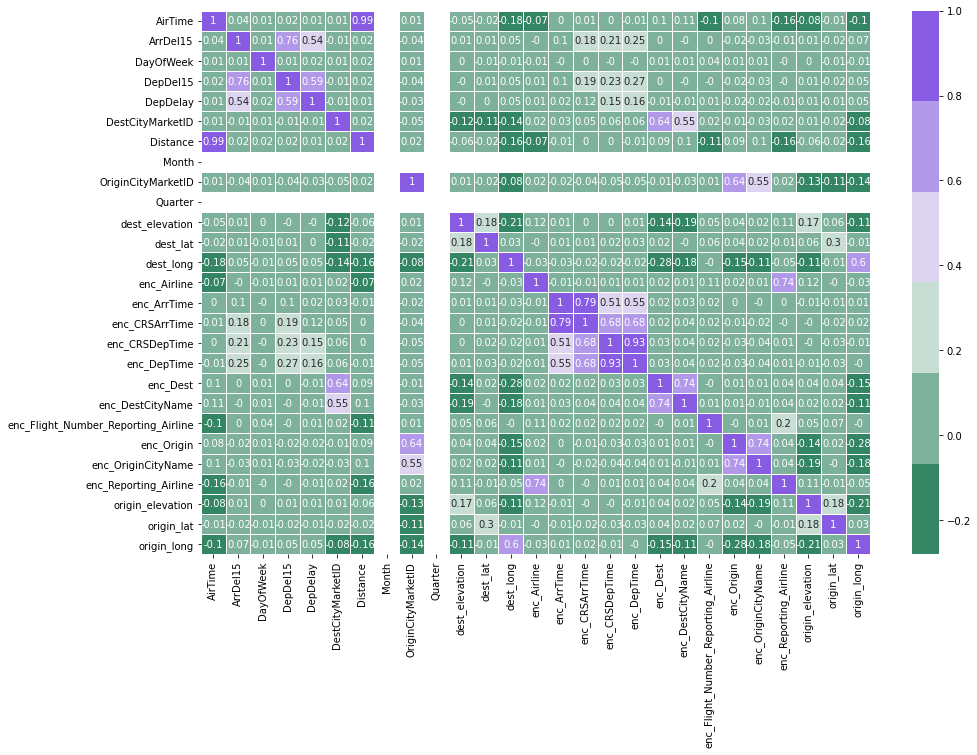

In [9]:
ax = sns.heatmap( data = numpy.round( cupy.asnumpy(cov), 2),
                  annot = True, linewidth = .5, 
                  cmap = sns.diverging_palette( 150, 275, s = 80 ),
                  xticklabels = correlation_columns,
                  yticklabels = correlation_columns,
                  figure = plt.figure(figsize=(15,10)) )

Take some time to observe the previous plot.

Values that you see in the cells are correlation coefficients that indicate how strong the relationship is. It ranges between -1 and 1. The closer it is to those extreme values, the stronger the linear relationship between two variables is. 
You should notice that cells with higher numbers have more intense color. This just makes it easier to find variables with stronger positive (purple) or negative (green) relationships. 

For your reference, you can see a clarification on the variables we used [here](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236). 

You can note a few important observations from the previous plot: 
1. Observe the variables that are highly correlated to our variable of interest: *ArrDel15*.<br/>
You might have noticed that this binary variable has a stronger linear relationship with other variables that indicate Arrival/Departure time and delay.

2. There is a perfect correlation between *ArrDelay* and *DepDelay* and a strong relationship (0.7) between binary indicators *ArrDel15* and *DepDel15*.<br/>
This tells us that if we know that one flight is about to depart earlier or later than scheduled, we can use this as a very strong indicator for an arrival delay.
A high correlation coefficient between *ArrDel15* and *DepDel15* tells us that delayed flights are very likely to arrive at their destination late. 

3. There are many variables in this dataset that are not linearly related to each other. However, later in this course, we will show that advanced ML algorithms can still deduce useful and actionable information from this data, even though simple ML algorithms (such as linear regression) might fare poorly against lack of linear relationships.


### <font color='#8735fb'> Geospatial Visualization

In this section, we will visualize all the flights originating from Seattle and Atlanta. Try visualizing the airport closest to you!

In [10]:
processed_data['OriginCityName']

0                Chicago, IL
1         Salt Lake City, UT
2                Chicago, IL
3            Springfield, MO
4                Chicago, IL
                 ...        
620882           Phoenix, AZ
620883           Memphis, TN
620884         Knoxville, TN
620885             Provo, UT
620886      Indianapolis, IN
Name: OriginCityName, Length: 620887, dtype: object

In [11]:
filtered = processed_data [processed_data['OriginCityName'] == 'Seattle, WA']
filtered['height'] = filtered['ArrDel15'] * 1 + filtered['ArrDelay'].scale()

In [12]:
renderer = teach_ML.geo_plot(filtered)
renderer.to_html(filename='geo.html', iframe_height = 500, iframe_width = 1200)

In [13]:
filtered = processed_data [processed_data['OriginCityName'] == 'Atlanta, GA']
filtered['height'] = filtered['ArrDel15'] * 1 + filtered['ArrDelay'].scale()

In [ ]:
renderer = teach_ML.geo_plot( filtered )
renderer.to_html( filename='geo.html', iframe_height = 500, iframe_width = 1200)

# <font color='#8735fb'> Summary
    
In this Notebook, we used our processed data to gain some intuition about the problem space. We visualized everything and used feature correlation coefficients to gain confidence that our features can be used to train an effective model.

<center><a href="https://developer.nvidia.com/machine-learning"><img src="img/nvidia.png" alt="nvidia_logo" style="width: 1500px;"/></a></center>